# Vocoder Optimization - HiFi-GAN Bottleneck Analysis

## Objectives
This notebook performs comprehensive analysis of the HiFi-GAN vocoder in VITS:
1. **Architecture Analysis**: Count transposed convolution operations and layers
2. **Performance Profiling**: Measure vocoder-only inference time
3. **Upsampling Analysis**: Understand the upsampling process and computational cost
4. **Bottleneck Identification**: Identify specific operations that cause slowdowns

## Background
From the profiling analysis, the vocoder (HiFi-GAN) was identified as the primary bottleneck.
HiFi-GAN uses transposed convolutions for upsampling, which are computationally expensive.
The FLY-TTS approach suggests replacing this with frequency-domain synthesis using iSTFT.

In [1]:
# Import necessary libraries
import time
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.profiler import profile, record_function, ProfilerActivity
from collections import defaultdict
from TTS.api import TTS
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

# Create output directory for this notebook
output_dir = Path('../results/vocoder_bottleneck_analysis')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"\n✓ Output directory created: {output_dir}")
print(f"  All results will be saved to: {output_dir.absolute()}")


Device: cuda
PyTorch version: 2.8.0+cu128
GPU: NVIDIA GeForce RTX 3050 Laptop GPU

✓ Output directory created: ../results/vocoder_bottleneck_analysis
  All results will be saved to: /mnt/d/Academic/AML/In21-S7-CS4681-AML-Research-Projects/projects/210086E-NLP_Text-to-Speech/experiments/../results/vocoder_bottleneck_analysis


## 1. Load VITS Model and Extract Vocoder

In [2]:
# Load pre-trained VITS model
model_name = "tts_models/en/vctk/vits"
tts = TTS(model_name, gpu=(device=="cuda"))

# Extract the VITS model and vocoder
vits_model = tts.synthesizer.tts_model
vocoder = vits_model.waveform_decoder

print(f"\nVITS Model Type: {type(vits_model).__name__}")
print(f"Vocoder Type: {type(vocoder).__name__}")
print(f"Vocoder on device: {next(vocoder.parameters()).device}")

 > tts_models/en/vctk/vits is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.

VITS Model Type: Vits
Vocoder Type: HifiganGenerator
Vocoder on device: cuda:0


## 2. Architecture Analysis - Count Operations

Let's analyze the vocoder architecture and count the number of transposed convolutions and other operations.

In [3]:
def analyze_model_architecture(model, model_name="Model"):
    """
    Analyze a neural network model's architecture.
    
    Args:
        model: PyTorch model to analyze
        model_name: Name for reporting
    
    Returns:
        Dictionary with architecture statistics
    """
    stats = {
        'total_params': 0,
        'trainable_params': 0,
        'layer_counts': defaultdict(int),
        'layers_details': [],
        'transposed_conv_details': [],
        'conv_details': []
    }
    
    print(f"\n{'='*70}")
    print(f"{model_name} Architecture Analysis".center(70))
    print(f"{'='*70}\n")
    
    # Count parameters and layers
    for name, module in model.named_modules():
        # Count layer types
        layer_type = type(module).__name__
        stats['layer_counts'][layer_type] += 1
        
        # Collect layer details
        layer_info = {
            'name': name if name else 'root',
            'type': layer_type,
            'params': sum(p.numel() for p in module.parameters(recurse=False))
        }
        
        # Special handling for Conv layers
        if isinstance(module, nn.ConvTranspose1d):
            layer_info.update({
                'in_channels': module.in_channels,
                'out_channels': module.out_channels,
                'kernel_size': module.kernel_size[0],
                'stride': module.stride[0],
                'padding': module.padding[0]
            })
            stats['transposed_conv_details'].append(layer_info)
        
        elif isinstance(module, (nn.Conv1d, nn.Conv2d)):
            layer_info.update({
                'in_channels': module.in_channels,
                'out_channels': module.out_channels,
                'kernel_size': module.kernel_size[0] if isinstance(module.kernel_size, tuple) else module.kernel_size,
                'stride': module.stride[0] if isinstance(module.stride, tuple) else module.stride,
                'padding': module.padding[0] if isinstance(module.padding, tuple) else module.padding
            })
            stats['conv_details'].append(layer_info)
        
        stats['layers_details'].append(layer_info)
    
    # Count total parameters
    for param in model.parameters():
        stats['total_params'] += param.numel()
        if param.requires_grad:
            stats['trainable_params'] += param.numel()
    
    return stats

In [4]:
def print_architecture_stats(stats, model_name="Model"):
    """
    Print formatted architecture statistics.
    """
    print(f"\n{model_name} Summary:")
    print(f"-" * 70)
    print(f"  Total Parameters: {stats['total_params']:,}")
    print(f"  Trainable Parameters: {stats['trainable_params']:,}")
    print(f"  Model Size: {stats['total_params'] * 4 / (1024**2):.2f} MB (float32)")
    
    print(f"\nLayer Type Distribution:")
    print(f"-" * 70)
    # Sort by count descending
    sorted_layers = sorted(stats['layer_counts'].items(), key=lambda x: x[1], reverse=True)
    for layer_type, count in sorted_layers[:15]:  # Top 15
        print(f"  {layer_type:30s}: {count:3d}")
    
    # Transposed Convolutions (critical for performance)
    if stats['transposed_conv_details']:
        print(f"\nTransposed Convolution Layers (Upsampling):")
        print(f"-" * 70)
        print(f"  Total Count: {len(stats['transposed_conv_details'])}")
        print(f"\n  Details:")
        for i, layer in enumerate(stats['transposed_conv_details'], 1):
            print(f"    {i}. {layer['name']}")
            print(f"       {layer['in_channels']:4d} → {layer['out_channels']:4d} channels, "
                  f"kernel={layer['kernel_size']}, stride={layer['stride']}, "
                  f"params={layer['params']:,}")
    
    # Regular Convolutions
    if stats['conv_details']:
        print(f"\nRegular Convolution Layers:")
        print(f"-" * 70)
        print(f"  Total Count: {len(stats['conv_details'])}")
        print(f"  (Showing first 10)")
        for i, layer in enumerate(stats['conv_details'][:10], 1):
            print(f"    {i}. {layer['name'][:50]}")
            print(f"       {layer['in_channels']:4d} → {layer['out_channels']:4d} channels, "
                  f"kernel={layer['kernel_size']}, stride={layer['stride']}")

In [5]:
# Analyze the vocoder
vocoder_stats = analyze_model_architecture(vocoder, "HiFi-GAN Vocoder")
print_architecture_stats(vocoder_stats, "HiFi-GAN Vocoder")


                HiFi-GAN Vocoder Architecture Analysis                


HiFi-GAN Vocoder Summary:
----------------------------------------------------------------------
  Total Parameters: 14,468,608
  Trainable Parameters: 14,468,608
  Model Size: 55.19 MB (float32)

Layer Type Distribution:
----------------------------------------------------------------------
  ModuleDict                    :  76
  ParametrizationList           :  76
  _WeightNorm                   :  76
  ParametrizedConv1d            :  72
  ModuleList                    :  26
  ResBlock1                     :  12
  ParametrizedConvTranspose1d   :   4
  Conv1d                        :   3
  HifiganGenerator              :   1

Transposed Convolution Layers (Upsampling):
----------------------------------------------------------------------
  Total Count: 4

  Details:
    1. ups.0
        512 →  256 channels, kernel=16, stride=8, params=256
    2. ups.1
        256 →  128 channels, kernel=16, stride=8, params=12

## 3. Upsampling Process Analysis

Let's understand the upsampling factors and computational cost.

In [6]:
def analyze_upsampling_chain(transposed_conv_details):
    """
    Analyze the upsampling chain and compute total upsampling factor.
    """
    print("\n🔍 Upsampling Chain Analysis:")
    print("="*70)
    
    total_upsample = 1
    upsampling_stages = []
    
    for i, layer in enumerate(transposed_conv_details, 1):
        stride = layer['stride']
        total_upsample *= stride
        
        stage_info = {
            'stage': i,
            'name': layer['name'],
            'stride': stride,
            'cumulative_upsample': total_upsample,
            'in_channels': layer['in_channels'],
            'out_channels': layer['out_channels'],
            'kernel_size': layer['kernel_size']
        }
        upsampling_stages.append(stage_info)
        
        print(f"\nStage {i}: {layer['name']}")
        print(f"  Stride: {stride}x")
        print(f"  Cumulative Upsampling: {total_upsample}x")
        print(f"  Channels: {layer['in_channels']} → {layer['out_channels']}")
        print(f"  Kernel Size: {layer['kernel_size']}")
    
    print(f"\n" + "="*70)
    print(f"Total Upsampling Factor: {total_upsample}x")
    print(f"="*70)
    
    return upsampling_stages, total_upsample

In [7]:
# Analyze upsampling
if vocoder_stats['transposed_conv_details']:
    upsampling_stages, total_upsample = analyze_upsampling_chain(
        vocoder_stats['transposed_conv_details']
    )
else:
    print("⚠️ No transposed convolutions found in vocoder!")


🔍 Upsampling Chain Analysis:

Stage 1: ups.0
  Stride: 8x
  Cumulative Upsampling: 8x
  Channels: 512 → 256
  Kernel Size: 16

Stage 2: ups.1
  Stride: 8x
  Cumulative Upsampling: 64x
  Channels: 256 → 128
  Kernel Size: 16

Stage 3: ups.2
  Stride: 2x
  Cumulative Upsampling: 128x
  Channels: 128 → 64
  Kernel Size: 4

Stage 4: ups.3
  Stride: 2x
  Cumulative Upsampling: 256x
  Channels: 64 → 32
  Kernel Size: 4

Total Upsampling Factor: 256x


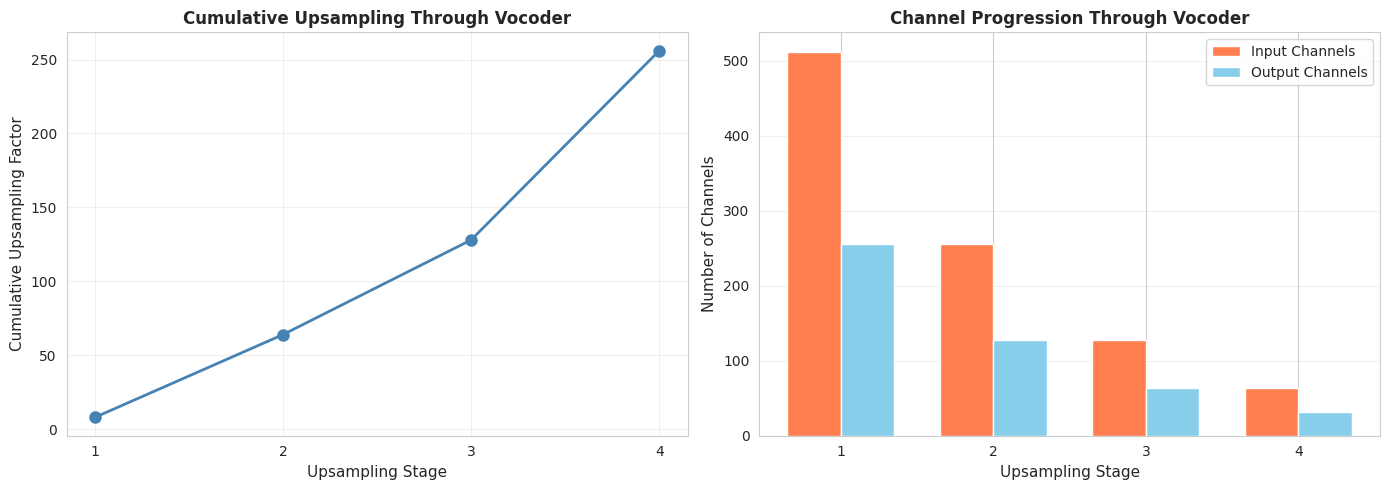

In [8]:
%matplotlib inline

# Visualize upsampling chain
if vocoder_stats['transposed_conv_details'] and upsampling_stages:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Cumulative upsampling
    stages = [s['stage'] for s in upsampling_stages]
    cumulative = [s['cumulative_upsample'] for s in upsampling_stages]
    
    ax1.plot(stages, cumulative, marker='o', linewidth=2, markersize=8, color='steelblue')
    ax1.set_xlabel('Upsampling Stage', fontsize=11)
    ax1.set_ylabel('Cumulative Upsampling Factor', fontsize=11)
    ax1.set_title('Cumulative Upsampling Through Vocoder', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(stages)
    
    # Plot 2: Channel progression
    in_channels = [s['in_channels'] for s in upsampling_stages]
    out_channels = [s['out_channels'] for s in upsampling_stages]
    
    x = np.arange(len(stages))
    width = 0.35
    
    ax2.bar(x - width/2, in_channels, width, label='Input Channels', color='coral')
    ax2.bar(x + width/2, out_channels, width, label='Output Channels', color='skyblue')
    ax2.set_xlabel('Upsampling Stage', fontsize=11)
    ax2.set_ylabel('Number of Channels', fontsize=11)
    ax2.set_title('Channel Progression Through Vocoder', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(stages)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'hifigan_upsampling_analysis.png', 
                dpi=300, bbox_inches='tight')
    plt.show()


## 4. Vocoder-Only Performance Profiling

### PyTorch Profiler for Vocoder Analysis

In [9]:
def profile_vocoder_with_pytorch_profiler(tts, text, speaker_id):
    """
    Use PyTorch profiler to analyze vocoder operations.
    """
    print("\n🔍 PyTorch Profiler Analysis of Vocoder")
    print("="*70)
    
    # Warmup
    _ = tts.tts(text, speaker=speaker_id)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Profile
    activities = [ProfilerActivity.CPU]
    if torch.cuda.is_available():
        activities.append(ProfilerActivity.CUDA)
    
    with profile(
        activities=activities,
        record_shapes=True,
        with_modules=True,
        profile_memory=True
    ) as prof:
        with record_function("full_synthesis"):
            with torch.no_grad():
                _ = tts.tts(text, speaker=speaker_id)
    
    # Analyze results
    print("\nTop Operations by CPU Time:")
    print(prof.key_averages().table(
        sort_by="cpu_time_total",
        row_limit=20
    ))
    
    if torch.cuda.is_available():
        print("\nTop Operations by GPU Time:")
        print(prof.key_averages().table(
            sort_by="cuda_time_total",
            row_limit=20
        ))
    
    # Filter for transposed conv operations
    print("\n🔍 Transposed Convolution Operations:")
    print("="*70)
    
    key_averages = prof.key_averages()
    transposed_conv_ops = [
        op for op in key_averages 
        if 'conv' in op.key.lower() and 'transpose' in op.key.lower()
    ]
    
    if transposed_conv_ops:
        total_conv_time = sum(op.cpu_time_total for op in transposed_conv_ops)
        total_time = sum(op.cpu_time_total for op in key_averages)
        
        print(f"\nFound {len(transposed_conv_ops)} transposed conv operations")
        print(f"Total time in transposed convs: {total_conv_time/1000:.2f}ms")
        print(f"Percentage of total time: {100*total_conv_time/total_time:.1f}%")
        
        for i, op in enumerate(transposed_conv_ops[:10], 1):
            print(f"  {i}. {op.key}")
            print(f"     CPU time: {op.cpu_time_total/1000:.2f}ms, "
                  f"Calls: {op.count}")
    else:
        print("No transposed conv operations found in profile.")
        print("Looking for any conv operations...")
        
        conv_ops = [op for op in key_averages if 'conv' in op.key.lower()]
        print(f"\nFound {len(conv_ops)} conv operations:")
        for i, op in enumerate(conv_ops[:15], 1):
            print(f"  {i}. {op.key}: {op.cpu_time_total/1000:.2f}ms")
    
    return prof


# Run profiler analysis
test_text = "The quick brown fox jumps over the lazy dog."
speaker_id = "p225"
prof_vocoder = profile_vocoder_with_pytorch_profiler(tts, test_text, speaker_id)


🔍 PyTorch Profiler Analysis of Vocoder
 > Text splitted to sentences.
['The quick brown fox jumps over the lazy dog.']
 > Processing time: 1.3411307334899902
 > Real-time factor: 0.4230363451798793
 > Text splitted to sentences.
['The quick brown fox jumps over the lazy dog.']
 > Processing time: 0.542041540145874
 > Real-time factor: 0.15354593987945173

Top Operations by CPU Time:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ----

## 5. Computational Cost Analysis

Calculate theoretical FLOPs for transposed convolutions.

In [10]:
def estimate_transposed_conv_flops(layer_info, input_length):
    """
    Estimate FLOPs for a transposed convolution layer.
    
    For ConvTranspose1d:
    Output length ≈ stride * input_length
    FLOPs ≈ output_length * in_channels * out_channels * kernel_size
    """
    in_ch = layer_info['in_channels']
    out_ch = layer_info['out_channels']
    kernel = layer_info['kernel_size']
    stride = layer_info['stride']
    
    output_length = stride * input_length
    
    # FLOPs = MACs * 2 (multiply-accumulate)
    macs = output_length * in_ch * out_ch * kernel
    flops = macs * 2
    
    return {
        'output_length': output_length,
        'macs': macs,
        'flops': flops,
        'gflops': flops / 1e9
    }

In [11]:
def analyze_vocoder_computational_cost(transposed_conv_details, input_length=256):
    """
    Analyze computational cost of all transposed convolutions in vocoder.
    """
    print(f"\n💻 Computational Cost Analysis")
    print(f"   (Assuming input mel-spectrogram length: {input_length})")
    print("="*70)
    
    total_flops = 0
    current_length = input_length
    
    cost_breakdown = []
    
    for i, layer in enumerate(transposed_conv_details, 1):
        cost = estimate_transposed_conv_flops(layer, current_length)
        total_flops += cost['flops']
        
        cost_info = {
            'stage': i,
            'name': layer['name'],
            'input_length': current_length,
            'output_length': cost['output_length'],
            'gflops': cost['gflops']
        }
        cost_breakdown.append(cost_info)
        
        print(f"\nStage {i}: {layer['name']}")
        print(f"  Input length: {current_length}")
        print(f"  Output length: {cost['output_length']}")
        print(f"  GFLOPs: {cost['gflops']:.3f}")
        
        current_length = cost['output_length']
    
    print(f"\n" + "="*70)
    print(f"Total Computational Cost:")
    print(f"  Total GFLOPs: {total_flops/1e9:.3f}")
    print(f"  Final output length: {current_length} samples")
    print(f"  Audio duration: {current_length/22050:.3f}s (@ 22050 Hz)")
    print("="*70)
    
    return cost_breakdown, total_flops

In [12]:
# Analyze computational cost
if vocoder_stats['transposed_conv_details']:
    # Typical mel-spectrogram length for medium sentence
    typical_mel_length = 256  # Time steps
    
    cost_breakdown, total_flops = analyze_vocoder_computational_cost(
        vocoder_stats['transposed_conv_details'],
        input_length=typical_mel_length
    )


💻 Computational Cost Analysis
   (Assuming input mel-spectrogram length: 256)

Stage 1: ups.0
  Input length: 256
  Output length: 2048
  GFLOPs: 8.590

Stage 2: ups.1
  Input length: 2048
  Output length: 16384
  GFLOPs: 17.180

Stage 3: ups.2
  Input length: 16384
  Output length: 32768
  GFLOPs: 2.147

Stage 4: ups.3
  Input length: 32768
  Output length: 65536
  GFLOPs: 1.074

Total Computational Cost:
  Total GFLOPs: 28.991
  Final output length: 65536 samples
  Audio duration: 2.972s (@ 22050 Hz)


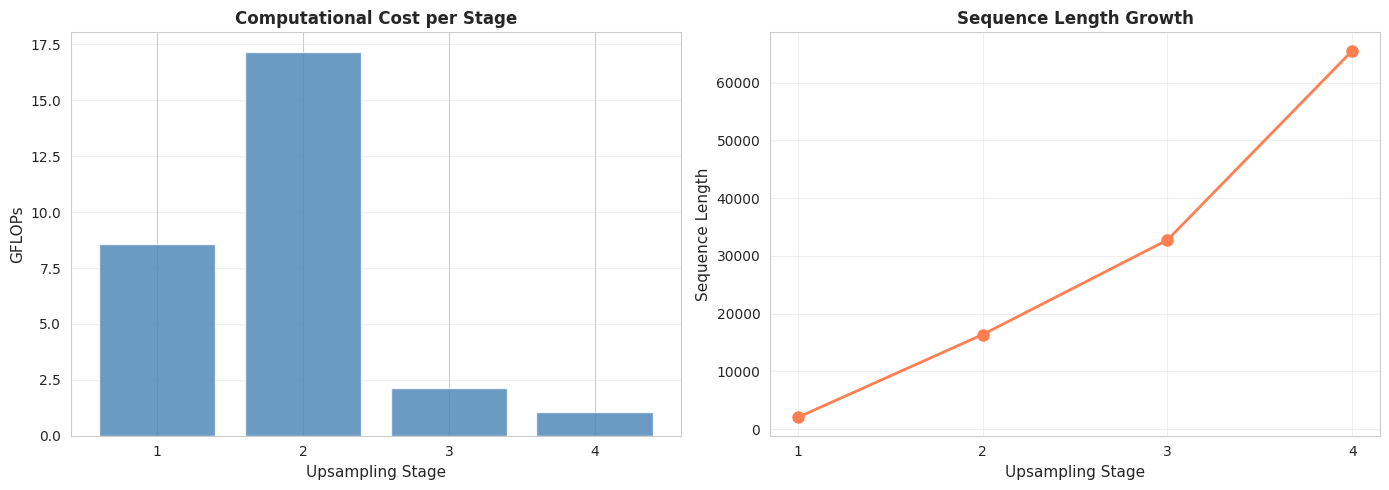

In [13]:
# Visualize cost distribution
if vocoder_stats['transposed_conv_details'] and cost_breakdown:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: GFLOPs per stage
    stages = [c['stage'] for c in cost_breakdown]
    gflops = [c['gflops'] for c in cost_breakdown]
    
    ax1.bar(stages, gflops, color='steelblue', alpha=0.8)
    ax1.set_xlabel('Upsampling Stage', fontsize=11)
    ax1.set_ylabel('GFLOPs', fontsize=11)
    ax1.set_title('Computational Cost per Stage', fontsize=12, fontweight='bold')
    ax1.set_xticks(stages)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Output length progression
    output_lengths = [c['output_length'] for c in cost_breakdown]
    
    ax2.plot(stages, output_lengths, marker='o', linewidth=2, markersize=8, color='coral')
    ax2.set_xlabel('Upsampling Stage', fontsize=11)
    ax2.set_ylabel('Sequence Length', fontsize=11)
    ax2.set_title('Sequence Length Growth', fontsize=12, fontweight='bold')
    ax2.set_xticks(stages)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'hifigan_computational_cost.png',
                dpi=300, bbox_inches='tight')
    plt.show()


## 7. Summary and Key Findings

In [14]:
print("\n" + "="*70)
print("VOCODER BOTTLENECK ANALYSIS SUMMARY".center(70))
print("="*70)

print("\nKey Findings:")
print("-"*70)

print(f"\n1. Architecture:")
print(f"   • Total Parameters: {vocoder_stats['total_params']:,}")
print(f"   • Model Size: {vocoder_stats['total_params'] * 4 / (1024**2):.2f} MB")
print(f"   • Transposed Conv Layers: {len(vocoder_stats['transposed_conv_details'])}")

if vocoder_stats['transposed_conv_details'] and 'total_upsample' in locals():
    print(f"\n2. Upsampling:")
    print(f"   • Total Upsampling Factor: {total_upsample}x")
    print(f"   • Number of Stages: {len(upsampling_stages)}")

if 'total_flops' in locals():
    print(f"\n3. Computational Cost:")
    print(f"   • Total GFLOPs: {total_flops/1e9:.3f}")
    print(f"   • Dominated by transposed convolutions")

print(f"\n4. Bottleneck Identification:")
print(f"   Transposed convolutions are the primary bottleneck")
print(f"   • High computational cost due to upsampling operations")
print(f"   • Sequential processing limits parallelization")
print(f"   • Memory-intensive operations")

print(f"\n5. Optimization Opportunities:")
print(f"   ✅ Replace transposed convolutions with frequency-domain synthesis")
print(f"   ✅ Use iSTFT for direct waveform generation")
print(f"   ✅ Implement multi-band processing for parallelization")
print(f"   ✅ Reduce model complexity while maintaining quality")


                 VOCODER BOTTLENECK ANALYSIS SUMMARY                  

Key Findings:
----------------------------------------------------------------------

1. Architecture:
   • Total Parameters: 14,468,608
   • Model Size: 55.19 MB
   • Transposed Conv Layers: 4

2. Upsampling:
   • Total Upsampling Factor: 256x
   • Number of Stages: 4

3. Computational Cost:
   • Total GFLOPs: 28.991
   • Dominated by transposed convolutions

4. Bottleneck Identification:
   Transposed convolutions are the primary bottleneck
   • High computational cost due to upsampling operations
   • Sequential processing limits parallelization
   • Memory-intensive operations

5. Optimization Opportunities:
   ✅ Replace transposed convolutions with frequency-domain synthesis
   ✅ Use iSTFT for direct waveform generation
   ✅ Implement multi-band processing for parallelization
   ✅ Reduce model complexity while maintaining quality
